# Análisis con Series de tiempo: Energia solar en Colombia

Este notebook realiza un análisis completo de modelos de series de tiempo aplicando métodos de suavización.

## Objetivos:
1. Entender la estructura y calidad de los datos una vez procesados en la etapa de procesamiento
2. Entendimiento de la serie de tiempo
3. Identificar la distribucción de los datos en serie de tiempo
4. Modelado
4.1 Suavización exponencial simple
4.2 Suavización exponencial Lineal (Holt)
4.3 Suavización exzponencial Lineal de Wilters (Holt-Winters)
4.4 Comparación de mdelos


In [38]:
import numpy as np
import pandas as pd  # Operaciones con dataframes
from matplotlib import pyplot as plt  # gráficos
from statsmodels.tsa.seasonal import seasonal_decompose  # descomposición de series
from statsmodels.tsa.holtwinters import SimpleExpSmoothing  # Holwinters simple
# Holwinters doble y tripe
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.exponential_smoothing.ets import ETSModel
from sklearn.metrics import mean_squared_error

# 1. Cargar y entender estructura de datos preprocesados

Nuestra primera tarea será leer el archivo csv preprocesado en la primera etapa. Para eso podemos emplear el paquete Pandas. Carguemos los datos en un objeto que denominaremos data.

In [62]:
# Importar funciones del notebook de utilidades
# Usamos %run para ejecutar el notebook completo y tener acceso a todas las funciones
%run ../utils/funcions.ipynb

# Verificar que la función está disponible
print("✓ Funciones importadas correctamente")

✓ Funciones importadas correctamente


In [40]:
# Carga de datos
# El archivo usa punto y coma como separador y coma como decimal
file_path = '../data/results/capacidad_acumulada_processed.csv'


df = load_capacidad_csv_data(file_path, sep=',', decimal='.')
df.head()


,Fecha,SOLAR,EOLICA,PCH
0,2019-01-31,42.539465,0.0,0.7
1,2019-02-28,42.539465,0.0,0.7
2,2019-03-31,42.539465,0.0,0.7
3,2019-04-30,42.539465,0.0,0.7
4,2019-05-31,43.595340,0.0,0.7


In [41]:
df.tail()

,Fecha,SOLAR,EOLICA,PCH
77,2025-06-30,2905.793884,41.0,20.615945
78,2025-07-31,2907.402217,41.0,20.615945
79,2025-08-31,2909.382217,41.0,20.615945
80,2025-09-30,2909.382217,41.0,20.615945
81,2025-10-31,2909.382217,41.0,20.615945


In [42]:
# seleccionando las columnas de interes
df = df[['Fecha', 'SOLAR']]
df['Fecha'] = pd.to_datetime(df['Fecha'], errors='coerce')
df['SOLAR'] = df['SOLAR'].astype(str).str.replace(',', '.').astype(float)
df = df.sort_values('Fecha')
df = df.set_index('Fecha')
df.head()

,SOLAR
Fecha,
2019-01-31,42.539465
2019-02-28,42.539465
2019-03-31,42.539465
2019-04-30,42.539465
2019-05-31,43.595340


Con los datos cargados, procedemos a graficar las métricas de energia SOLAR

## **2. Encontrando los componentes de la serie de tiempo**


Empezamos nuestro análisis descomponiendo la serie de tiempo en sus componentes: **tendencia**, **estacionalidad** y **componente puramente aleatorio**.

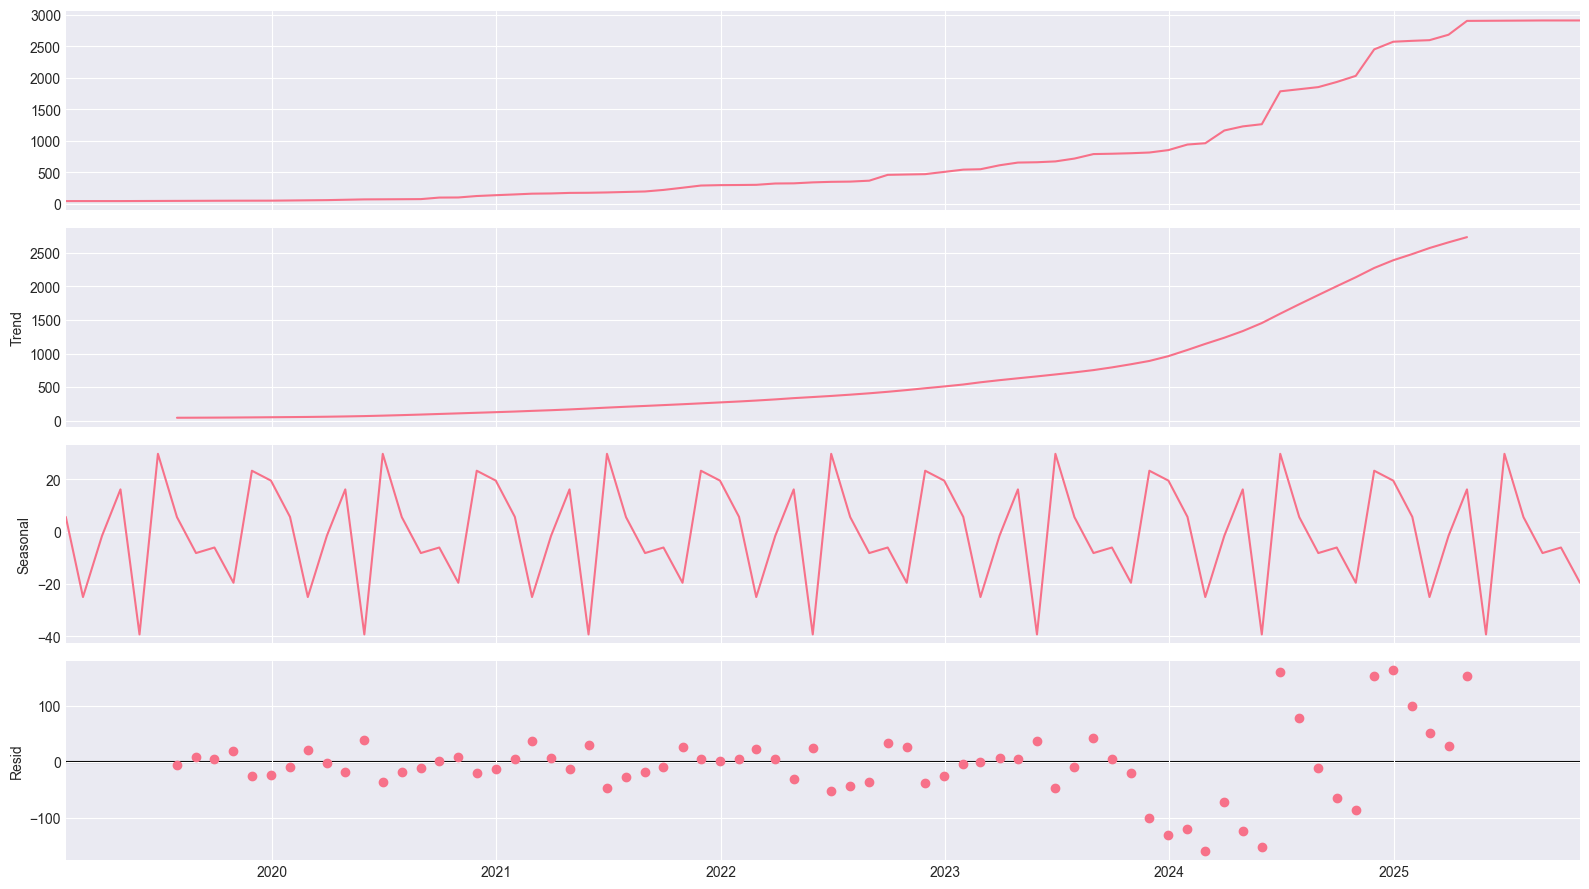

In [43]:
td_componentes = seasonal_decompose(df[["SOLAR"]],model="additive")
fig = td_componentes.plot()
fig.set_size_inches((16, 9))
fig.tight_layout()
plt.show()

Podemos observar el componente estacional marcado en la serie, una tendencia no lineal de los datos y la parte aleatoria.

Es importante mencionar que esta descomposición se emplea solo como referencia para iniciar el análisis.

Antes de entrar a trabajar con los métodos de suavizamiento, vale la pena anotar que una forma sencilla y rápida para quitar el componente estacional (desestacionalizar) es restarle a la serie el componente estacional encontrado en la descomposición. Es decir,

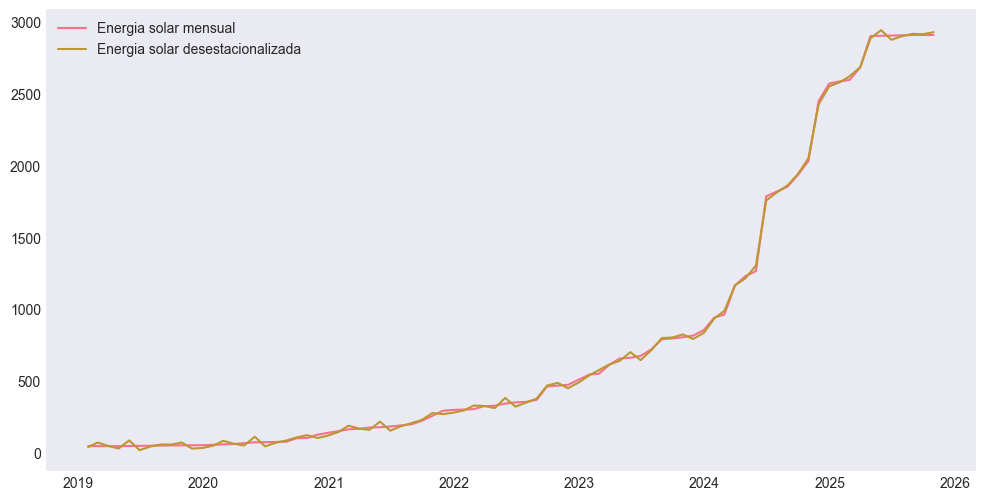

In [44]:
td_desestacionalizada = df["SOLAR"]-td_componentes.seasonal

plt.plot(df["SOLAR"],label="Energia solar mensual")
plt.plot(td_desestacionalizada,label="Energia solar desestacionalizada")
plt.legend()
plt.grid()
plt.show()

# 3. Identificar la distribucción de los datos en serie de tiempo

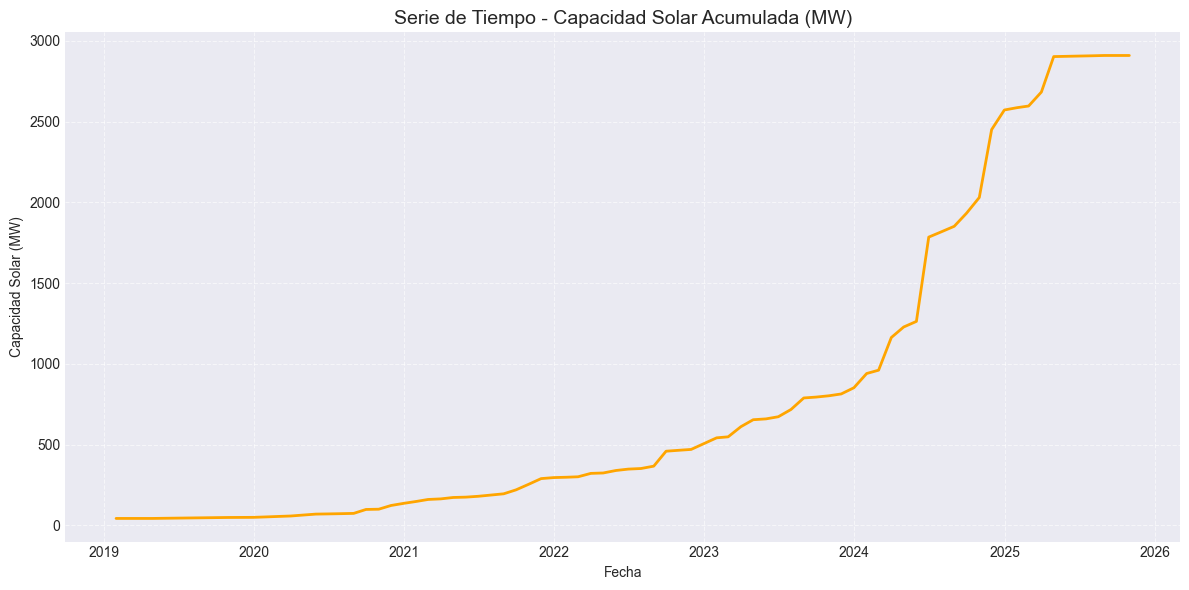

In [45]:
# Graficar la serie de tiempo continua
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['SOLAR'], color='orange', linewidth=2)
plt.title('Serie de Tiempo - Capacidad Solar Acumulada (MW)', fontsize=14)
plt.xlabel('Fecha')
plt.ylabel('Capacidad Solar (MW)')
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

# 4. Modelado


4.2 Suavización exponencial Lineal (Holt)
4.3 Suavización exzponencial Lineal de Wilters (Holt-Winters)
4.4 Comparación de mdelos

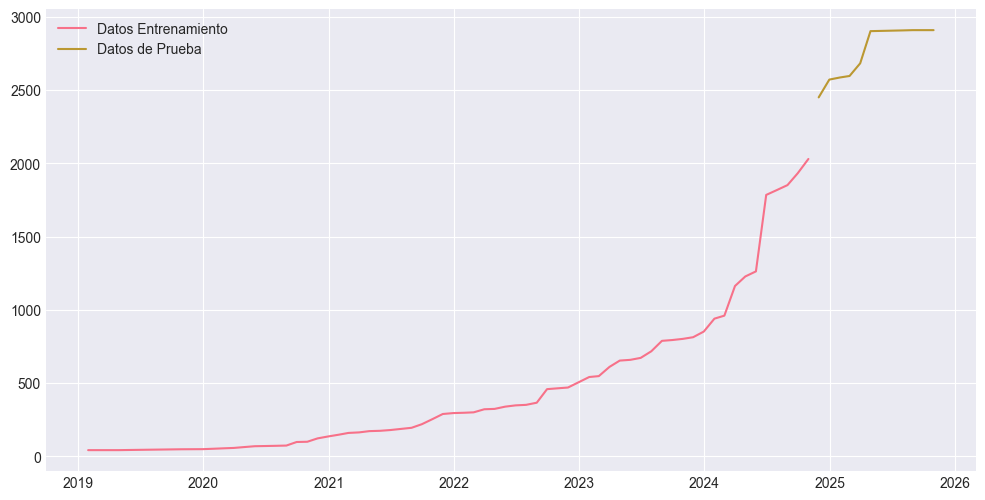

In [60]:
train_len = 70
train_td = df[["SOLAR"]][:train_len]
test_td = df[["SOLAR"]][train_len:]

fig = plt.figure(figsize=(12, 6))
plt.plot(train_td, label="Datos Entrenamiento")
plt.plot(test_td, label="Datos de Prueba")
plt.legend()
plt.show()

## 4.1 Suavización exponencial simple

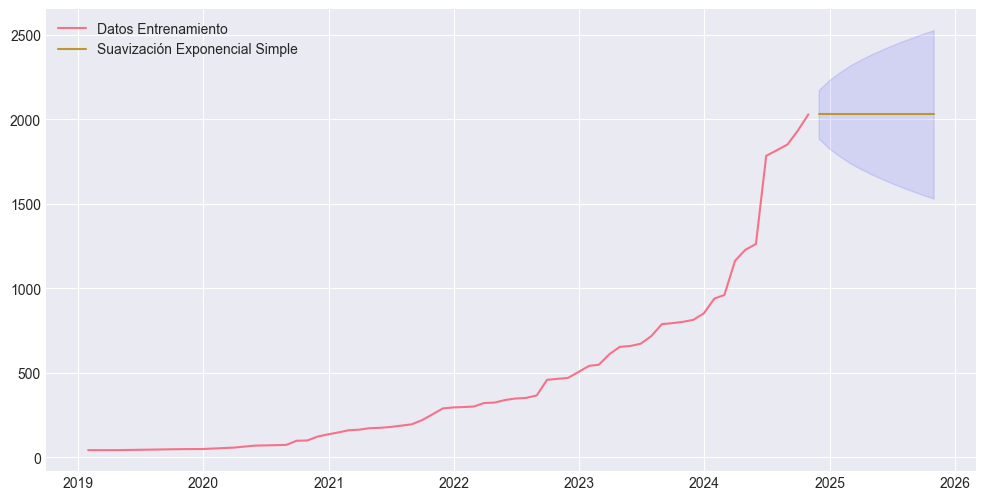

{'MSE': 575642.91091451, 'RMSE': np.float64(758.7113488768374), 'MAE': 739.5753265641188, 'R2': -19.077358541582296, 'MAPE': nan}


In [53]:
ets_model = ETSModel(endog=train_td["SOLAR"], error="add")
ets_result = ets_model.fit()

point_forecast = ets_result.forecast(12)

ci = ets_result.get_prediction(start=point_forecast.index[0],
                               end=point_forecast.index[-1])

conf_forecast = ci.pred_int(alpha=0.05)  # .iloc[:,0]
limits = ci.predicted_mean


preds = pd.concat([limits, conf_forecast], axis=1)
preds.columns = ['Point_forecast', 'lower_95', 'upper_95']
# print(preds)

fig = plt.figure(figsize=(12, 6))
plt.plot(train_td, label="Datos Entrenamiento")
plt.plot(preds['Point_forecast'], label="Suavización Exponencial Simple")
plt.fill_between(preds.index, preds['lower_95'],
                 preds['upper_95'], color='blue', alpha=0.1)
plt.legend()
plt.show()

print(calculate_metrics(test_td, point_forecast))



## 4.2 Suavización exponencial Lineal (Holt)

            Point_forecast     lower_95     upper_95
2024-11-30     2142.375365  2020.268938  2264.481792
2024-12-31     2248.432478  2081.198799  2415.666158
2025-01-31     2354.489592  2140.168081  2568.811103
2025-02-28     2460.546705  2196.744418  2724.348992
2025-03-31     2566.603819  2250.814710  2882.392928
2025-04-30     2672.660932  2302.378739  3042.943126
2025-05-31     2778.718046  2351.480503  3205.955588
2025-06-30     2884.775159  2398.181227  3371.369092
2025-07-31     2990.832273  2442.547710  3539.116836
2025-08-31     3096.889386  2484.647043  3709.131729
2025-09-30     3202.946500  2524.544202  3881.348797
2025-10-31     3309.003613  2562.301008  4055.706219


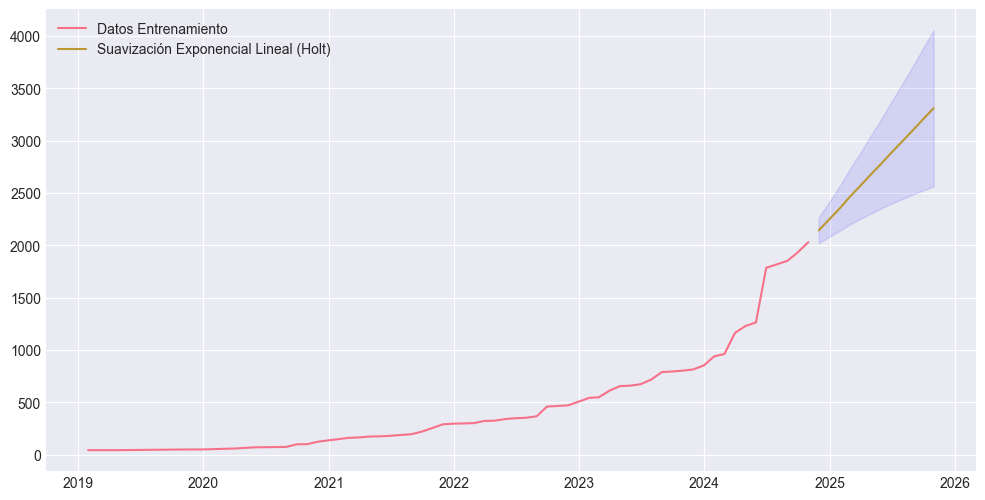

{'MSE': 53517.461643430375, 'RMSE': np.float64(231.33841367881465), 'MAE': 204.65907822076738, 'R2': -0.8665899384455453, 'MAPE': nan}


In [54]:
# Build model.
# ,seasonal="mul" )
ets_model = ETSModel(endog=train_td["SOLAR"], error="add", trend="add")
ets_result = ets_model.fit()

point_forecast = ets_result.forecast(12)

ci = ets_result.get_prediction(start=point_forecast.index[0],
                               end=point_forecast.index[-1])

conf_forecast = ci.pred_int(alpha=0.05)  # .iloc[:,0]
limits = ci.predicted_mean


preds_holt = pd.concat([limits, conf_forecast], axis=1)
preds_holt.columns = ['Point_forecast', 'lower_95', 'upper_95']
print(preds_holt)

fig = plt.figure(figsize=(12, 6))
plt.plot(train_td, label="Datos Entrenamiento")
plt.plot(preds_holt['Point_forecast'],
         label="Suavización Exponencial Lineal (Holt)")
plt.fill_between(preds_holt.index,
                 preds_holt['lower_95'], preds_holt['upper_95'], color='blue', alpha=0.1)
plt.legend()
plt.show()

print(calculate_metrics(test_td, point_forecast))

## 4.3 Suavizacion Exponencial Lineal de Winters (Holt-Winters) 

In [55]:
configurations = [
    ("add", "add", "add"),  # ETS(A,A,A)
    ("add", "add", "mul"),  # ETS(A,A,M)
    ("add", None, "add"),   # ETS(A,N,A)
    ("add", None, "mul"),   # ETS(A,N,M)
    ("mul", "add", None),   # ETS(M,A,N)
]

for err, trend, seas in configurations:
    model = ETSModel(endog=train_td["SOLAR"], error=err,
                     trend=trend, seasonal=seas)
    result = model.fit()
    forecast = result.forecast(len(test_td))
    print(calculate_metrics(test_td, point_forecast))

{'MSE': 53517.461643430375, 'RMSE': np.float64(231.33841367881465), 'MAE': 204.65907822076738, 'R2': -0.8665899384455453, 'MAPE': nan}
{'MSE': 53517.461643430375, 'RMSE': np.float64(231.33841367881465), 'MAE': 204.65907822076738, 'R2': -0.8665899384455453, 'MAPE': nan}
{'MSE': 53517.461643430375, 'RMSE': np.float64(231.33841367881465), 'MAE': 204.65907822076738, 'R2': -0.8665899384455453, 'MAPE': nan}
{'MSE': 53517.461643430375, 'RMSE': np.float64(231.33841367881465), 'MAE': 204.65907822076738, 'R2': -0.8665899384455453, 'MAPE': nan}
{'MSE': 53517.461643430375, 'RMSE': np.float64(231.33841367881465), 'MAE': 204.65907822076738, 'R2': -0.8665899384455453, 'MAPE': nan}


In [56]:
# Build model
ets_model = ETSModel(
    endog=train_td["SOLAR"], error="mul", trend="add", seasonal=None)
ets_result = ets_model.fit()

point_forecast = ets_result.forecast(12)

ci = ets_result.get_prediction(start=point_forecast.index[0],
                               end=point_forecast.index[-1])

conf_forecast = ci.pred_int(alpha=0.05)  # .iloc[:,0]
limits = ci.predicted_mean


preds_hw_add = pd.concat([limits, conf_forecast], axis=1)
preds_hw_add.columns = ['Point_forecast', 'lower_95', 'upper_95']
print(preds_hw_add)

            Point_forecast     lower_95     upper_95
2024-11-30     2137.740351  1835.781591  2438.721743
2024-12-31     2238.604681  1808.763414  2741.322400
2025-01-31     2339.469012  1744.178229  3004.766121
2025-02-28     2440.333343  1665.141601  3310.020861
2025-03-31     2541.197673  1610.000553  3655.704719
2025-04-30     2642.062004  1459.846293  4113.671568
2025-05-31     2742.926335  1364.760794  4511.710174
2025-06-30     2843.790665  1243.276614  5028.182458
2025-07-31     2944.654996  1090.467480  5498.989708
2025-08-31     3045.519327   977.256587  6099.297533
2025-09-30     3146.383657   862.209682  6391.283919
2025-10-31     3247.247988   711.433572  7240.801738


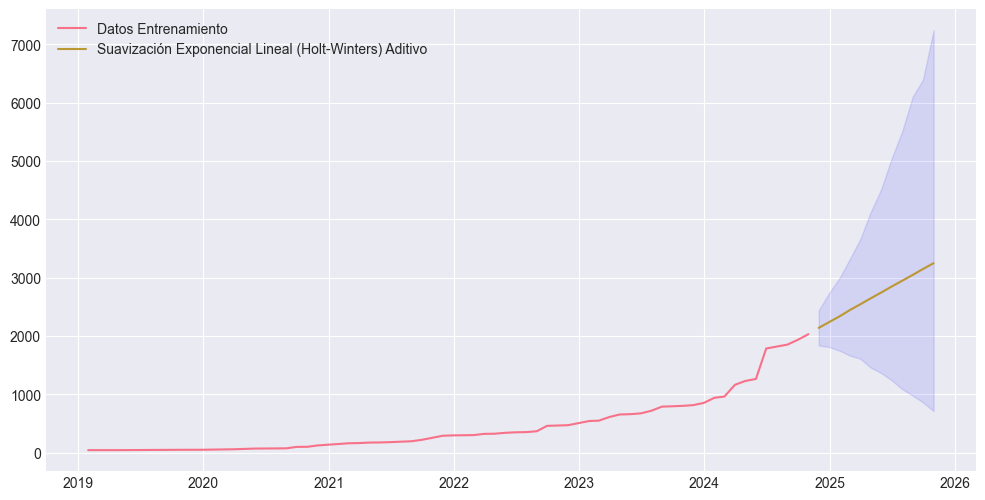

In [57]:
fig = plt.figure(figsize=(12, 6))
plt.plot(train_td, label="Datos Entrenamiento")
plt.plot(preds_hw_add['Point_forecast'],
         label="Suavización Exponencial Lineal (Holt-Winters) Aditivo")
plt.fill_between(preds_hw_add.index,
                 preds_hw_add['lower_95'], preds_hw_add['upper_95'], color='blue', alpha=0.1)
plt.legend()
plt.show()

In [58]:
#print(ets_result.alpha, ets_result.beta,ets_result.gamma)
print(ets_result.alpha, ets_result.beta)

0.7815743507634634 0.27591818144537067


In [59]:
print(calculate_metrics(test_td, preds_hw_add['Point_forecast']))

{'MSE': 50175.30978468867, 'RMSE': np.float64(223.9984593355246), 'MAE': 201.87676393372917, 'R2': -0.7500218718610541, 'MAPE': nan}


In [78]:
def graficar_pronosticos(lista_modelos, meses_pronostico=12):

    rmse_dict = {}

    for idx, modelo in enumerate(lista_modelos):
        nombre = modelo['nombre']
        tipo = modelo['tipo']

        ets_model = ETSModel(
                    endog=train_td["SOLAR"],
                    error=modelo.get('error', 'add'),
                    trend=modelo.get('trend', None),
                    seasonal=modelo.get('seasonal', None)
                )
        ets_result = ets_model.fit()

        point_forecast=ets_result.forecast(meses_pronostico)

        ci = ets_result.get_prediction(start = point_forecast.index[0],end = point_forecast.index[-1])

        conf_forecast = ci.pred_int(alpha=0.05)#.iloc[:,0]
        limits = ci.predicted_mean

        preds_hw_mul = pd.concat([limits, conf_forecast], axis = 1)
        preds_hw_mul.columns = ['Point_forecast', 'lower_95', 'upper_95']
        #print(preds_hw_mul)

        rmse = np.sqrt(mean_squared_error(test_td,preds_hw_mul['Point_forecast']))
        print(rmse)
        
        # Agregar nombre y RMSE al diccionario
        rmse_dict[nombre] = rmse

        fig = plt.figure(figsize=(14, 6))
        plt.plot(train_td,label="Datos Entrenamiento")
        plt.plot(preds_hw_mul['Point_forecast'],label="Suavización Exponencial "+nombre + " (RMSE: "+str(rmse)+")")
        plt.fill_between(preds_hw_mul.index ,preds_hw_mul['lower_95'], preds_hw_mul['upper_95'], color='blue', alpha=0.1)
        plt.legend()
        plt.show()

        
    

    # Encontrar el mejor modelo
    if rmse_dict:
        mejor_modelo = min(rmse_dict.items(), key=lambda x: x[1])
        print(f"Comparación de RMSE para cada modelo suavisado:")
        for modelo, rmse_valor in rmse_dict.items():
            print(f"{modelo}: {rmse_valor:.4f}")
        print(f"\nEl mejor modelo es {mejor_modelo[0]} con RMSE = {mejor_modelo[1]:.4f}")

        # Generar pronóstico para los siguientes 6 meses con el mejor modelo
        if mejor_modelo[0].startswith('MA'):
            # Si el mejor modelo es un promedio móvil
            ventana = int(mejor_modelo[0][-2])
            pronostico = fore_ma(data[["SOLAR"]], ventana, 6)
        else:
            # Para modelos de suavización exponencial
            ets_model = ETSModel(
                endog=df["SOLAR"],
                error="add",
                trend=None if mejor_modelo[0] == 'SES' else "add",
                seasonal="mul" if mejor_modelo[0] == 'Holt-Winters Multiplicativo' else ("add" if mejor_modelo[0] == 'Holt-Winters Aditivo' else None)
            )
            ets_result = ets_model.fit()
            pronostico = ets_result.forecast(6)
            
        print("\nPronóstico para los próximos 12 meses:")
        print(pronostico)
    else:
        print("⚠ No se calcularon RMSEs para ningún modelo.")
    
    # Visualización del pronóstico
    plt.figure(figsize=(15, 6))
    plt.plot(df["SOLAR"], label="Datos históricos", color='blue')
    plt.plot(pronostico, label="Pronóstico", color='red', linestyle='--')
    plt.title("Pronóstico solar para los próximos 12 meses")
    plt.xlabel("Fecha")
    plt.ylabel("SOLAR (MW)")
    plt.legend()
    plt.grid(True)
    plt.show()

758.7113488768374


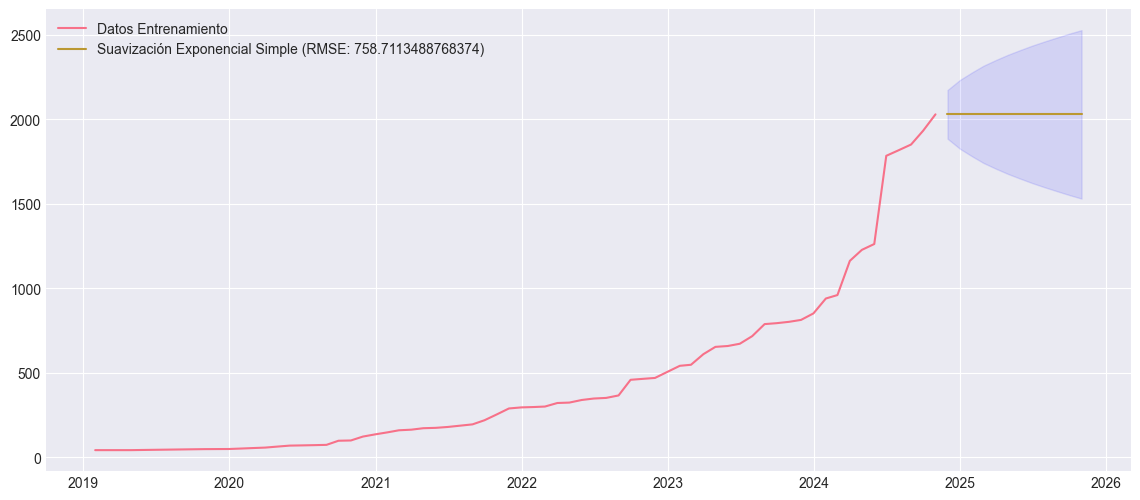

231.33841367881465


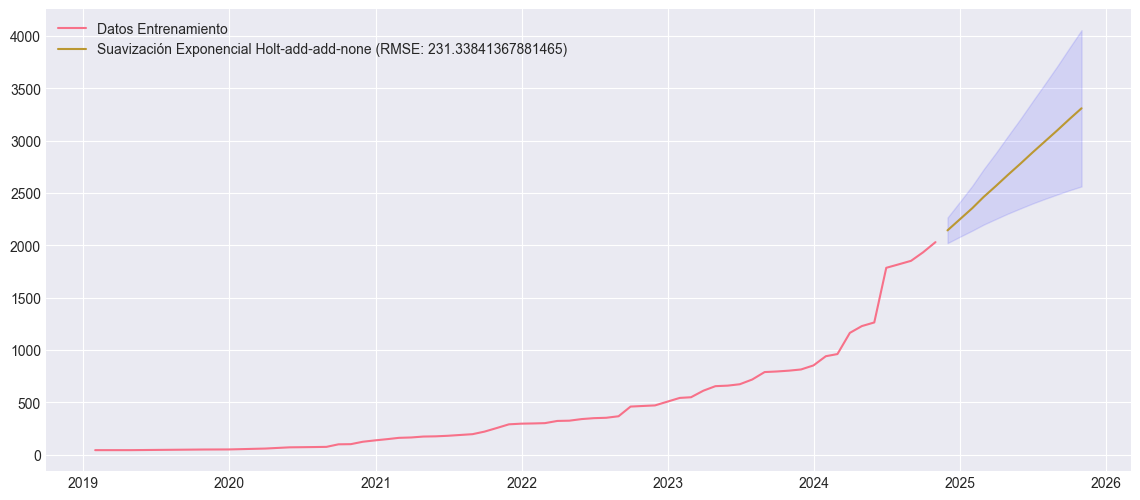

818.9308388420696


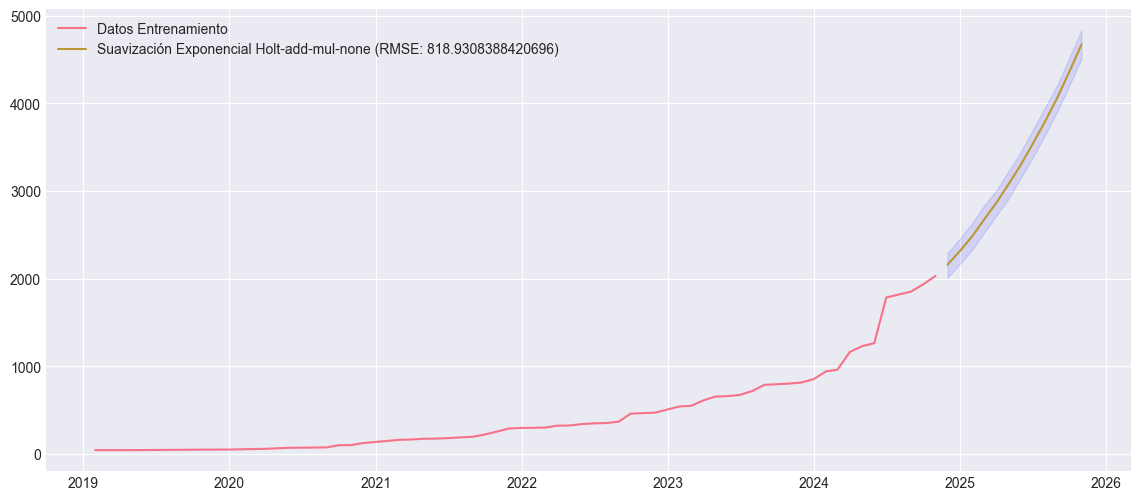

223.9984593355246


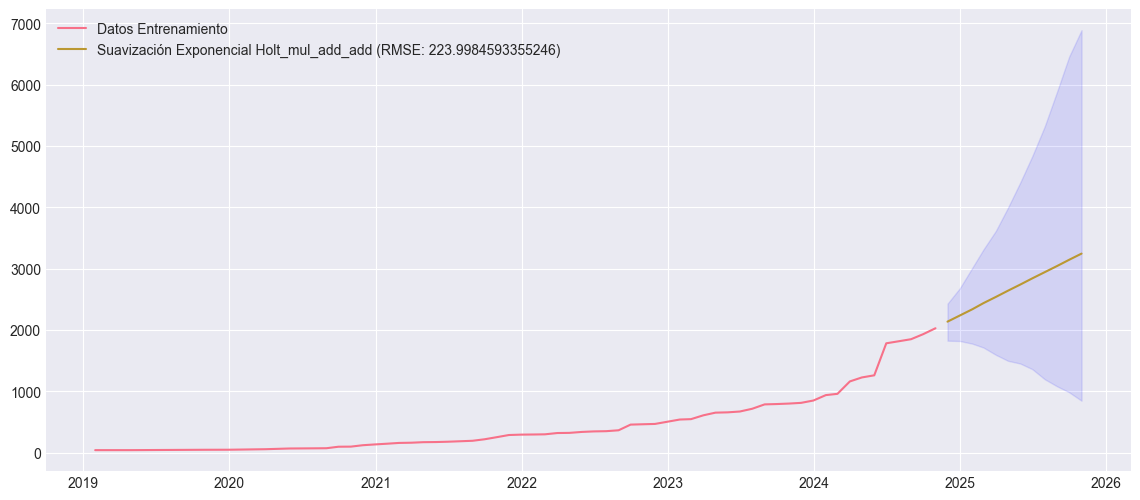

532.8697119789028


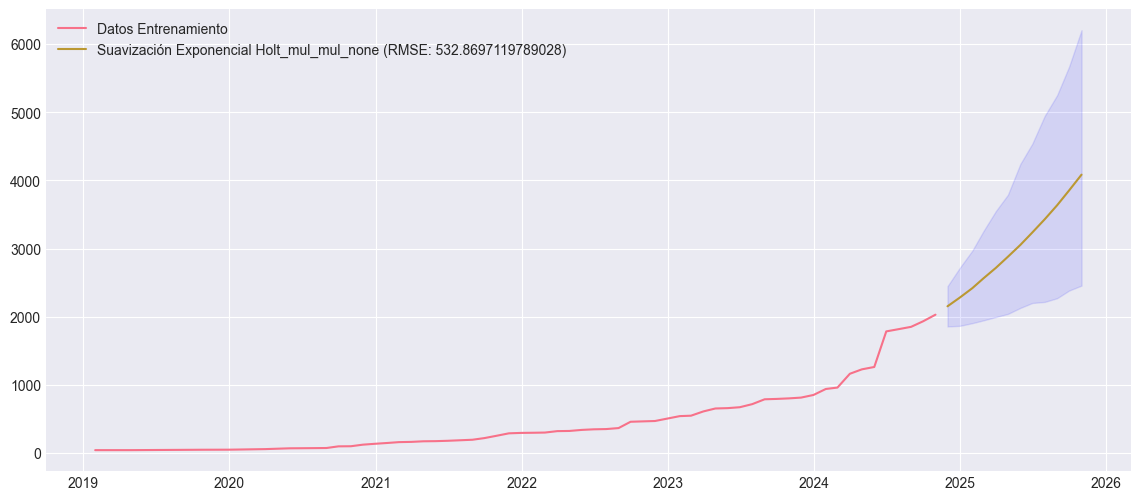

241.6468807978642


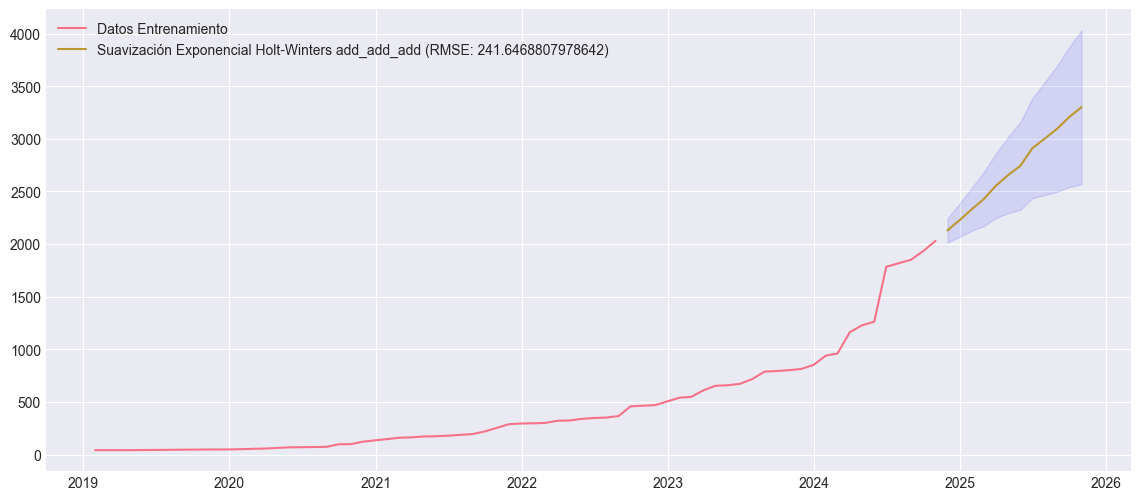

393.3249677216468


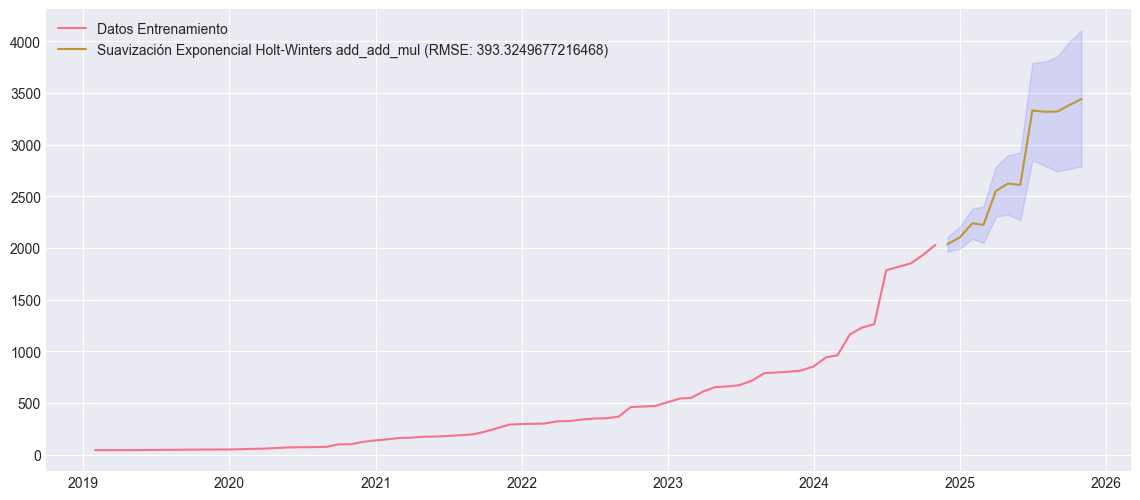

711.1731836100721


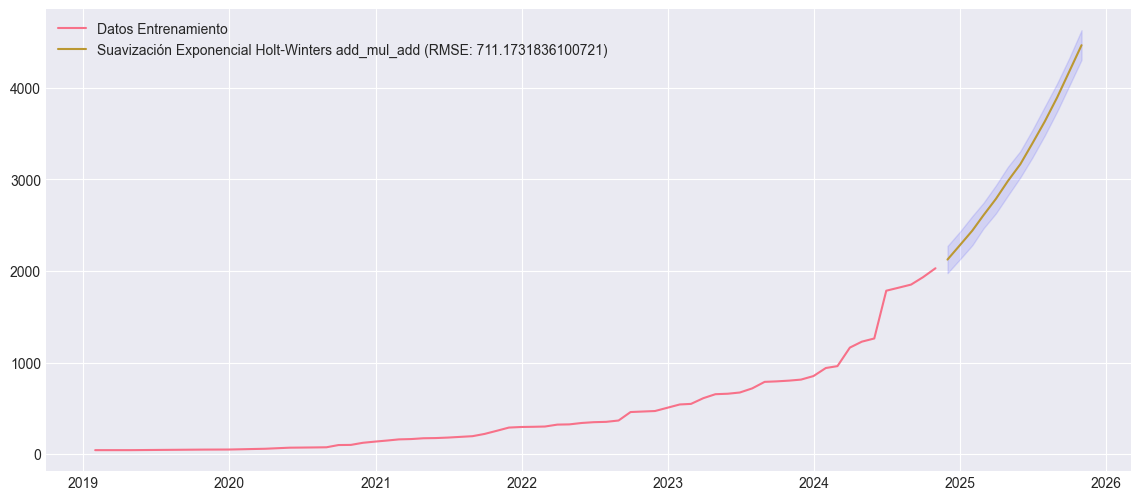

935.8637982187164


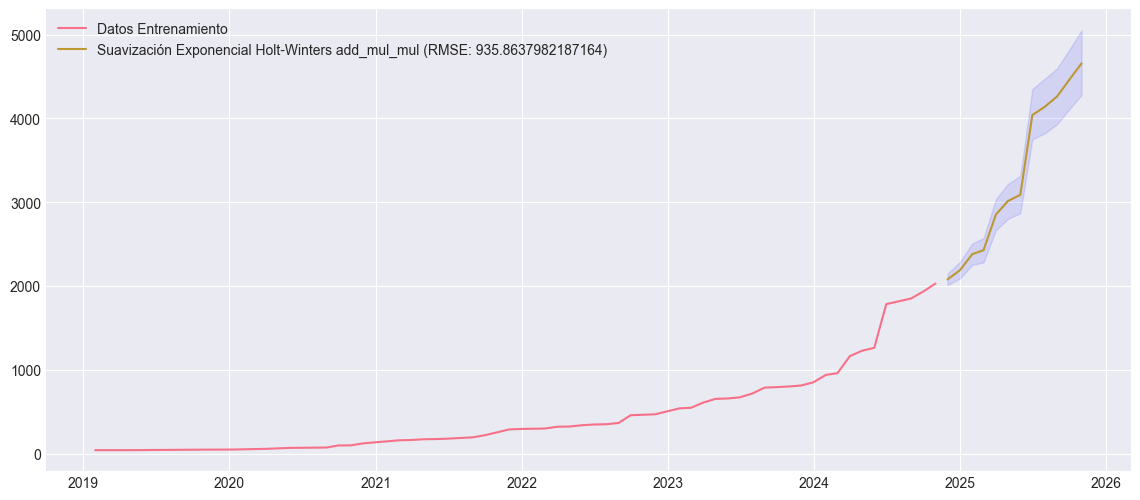

221.13855115132105


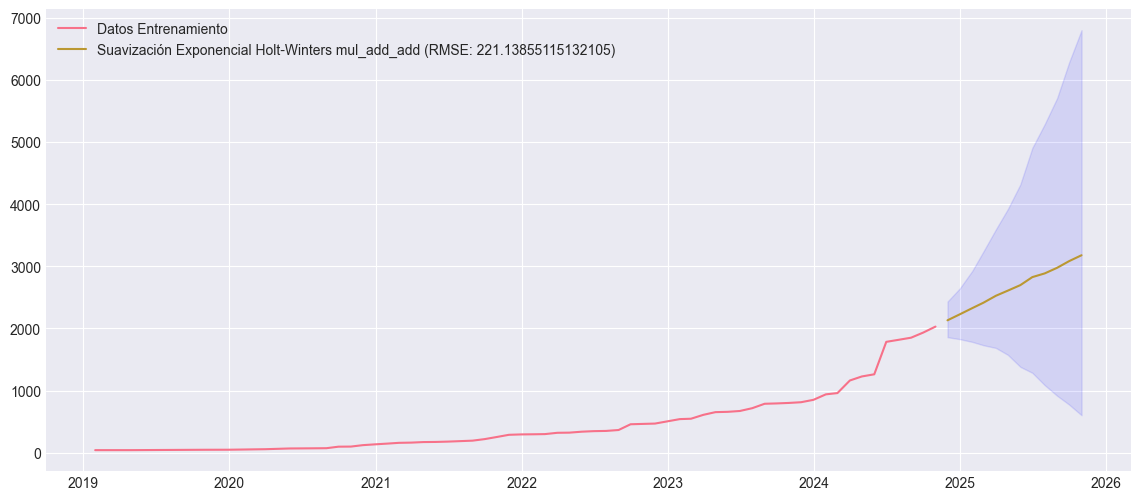

284.14944574233795


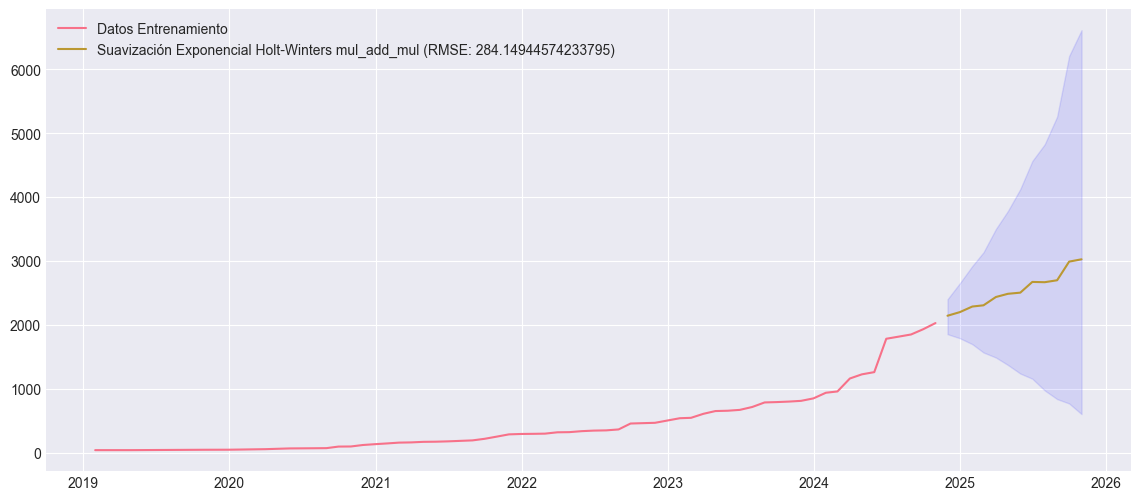

520.347802904826


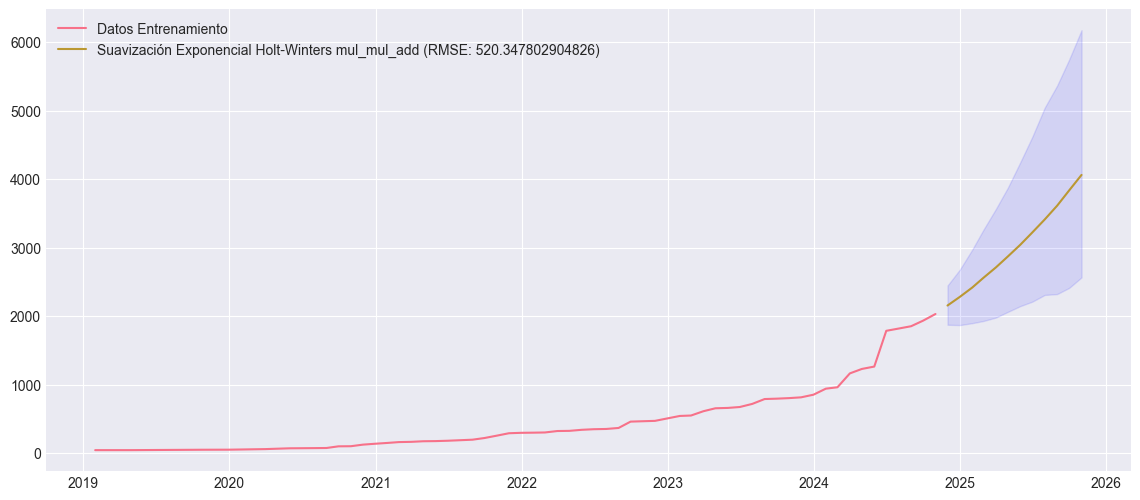

507.7044942260494


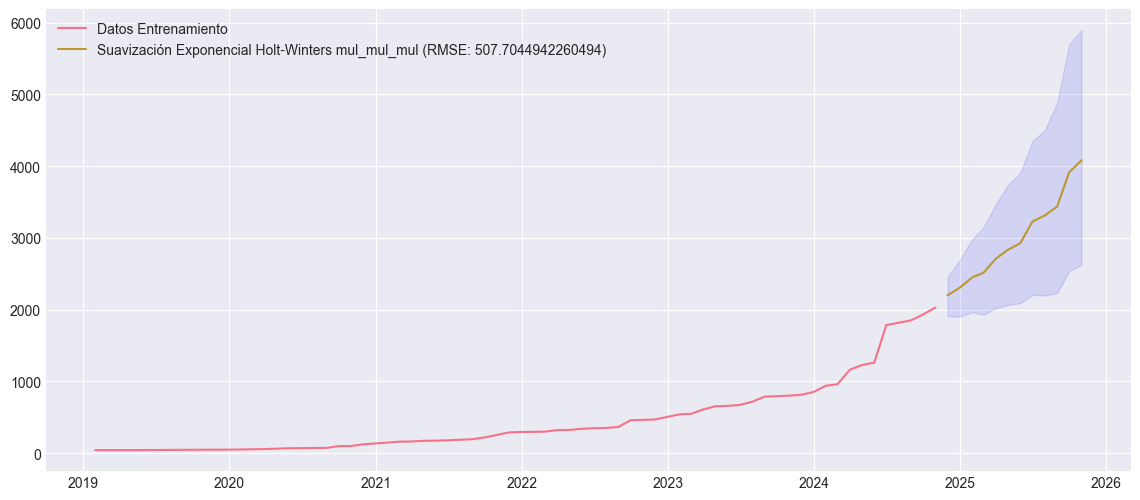

779.3930373673608


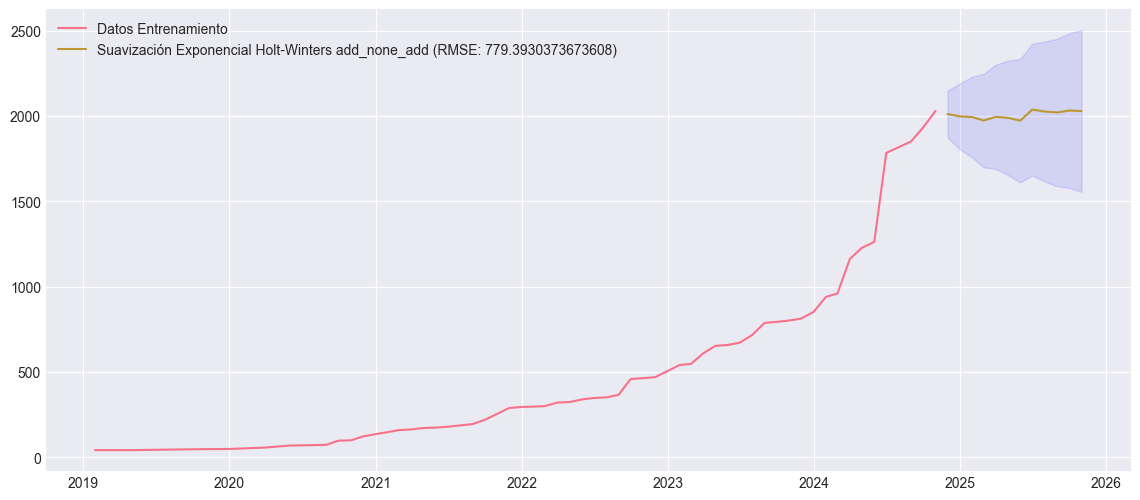

1016.6497773043717


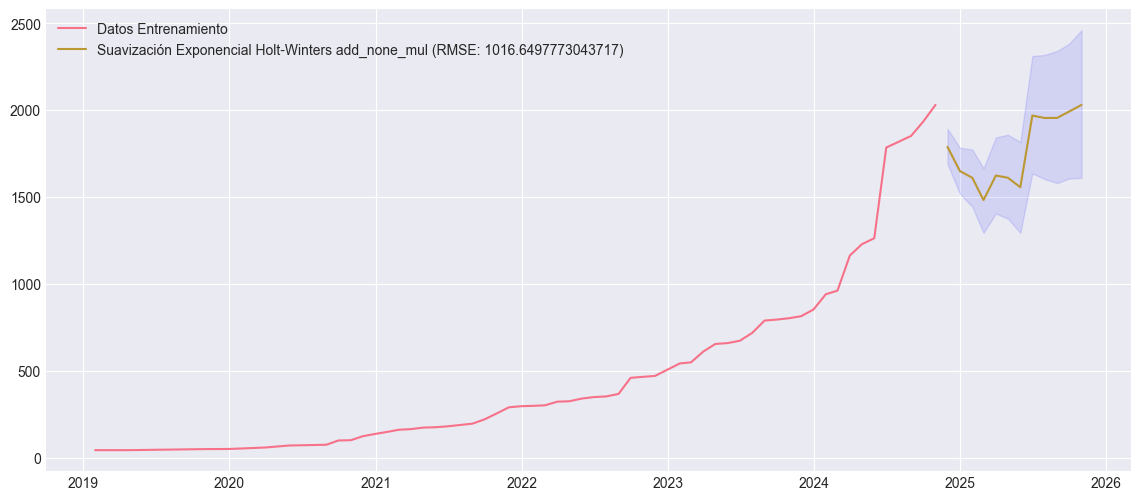

760.1949892155217


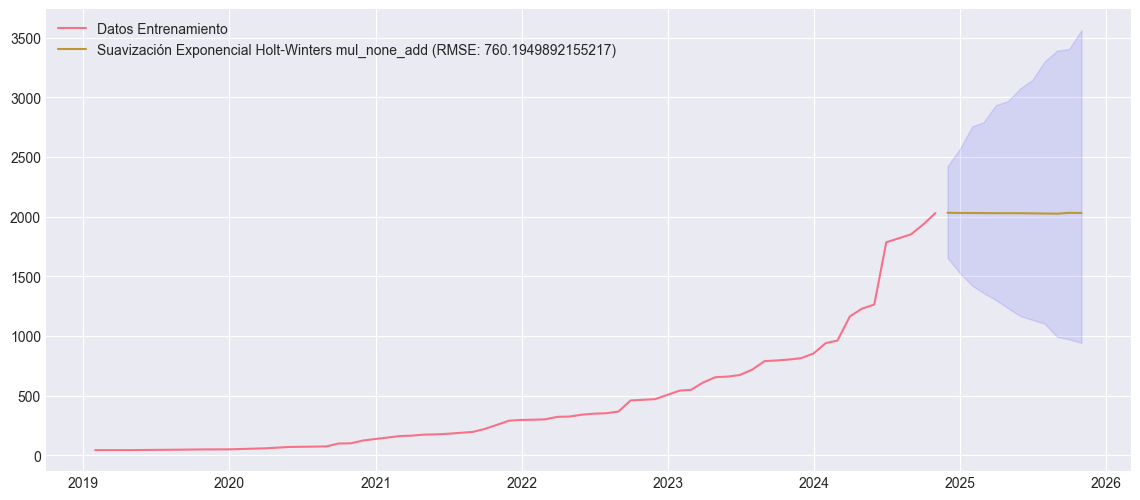

801.7279209115418


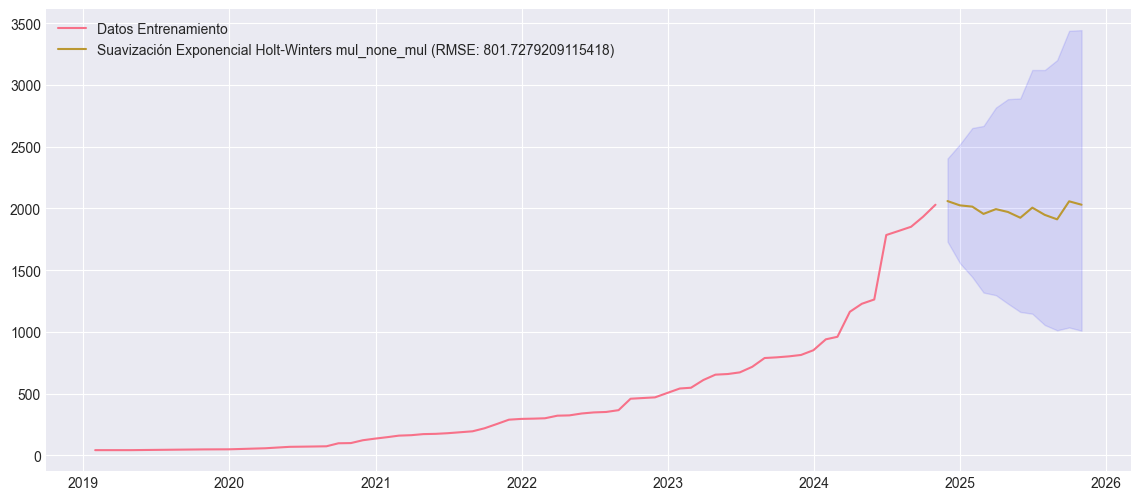

Comparación de RMSE para cada modelo suavisado:
Simple: 758.7113
Holt-add-add-none: 231.3384
Holt-add-mul-none: 818.9308
Holt_mul_add_add: 223.9985
Holt_mul_mul_none: 532.8697
Holt-Winters add_add_add: 241.6469
Holt-Winters add_add_mul: 393.3250
Holt-Winters add_mul_add: 711.1732
Holt-Winters add_mul_mul: 935.8638
Holt-Winters mul_add_add: 221.1386
Holt-Winters mul_add_mul: 284.1494
Holt-Winters mul_mul_add: 520.3478
Holt-Winters mul_mul_mul: 507.7045
Holt-Winters add_none_add: 779.3930
Holt-Winters add_none_mul: 1016.6498
Holt-Winters mul_none_add: 760.1950
Holt-Winters mul_none_mul: 801.7279

El mejor modelo es Holt-Winters mul_add_add con RMSE = 221.1386

Pronóstico para los próximos 12 meses:
2025-11-30    2954.919169
2025-12-31    2996.944895
2026-01-31    3038.970622
2026-02-28    3080.996348
2026-03-31    3123.022075
2026-04-30    3165.047801
Freq: ME, Name: simulation, dtype: float64


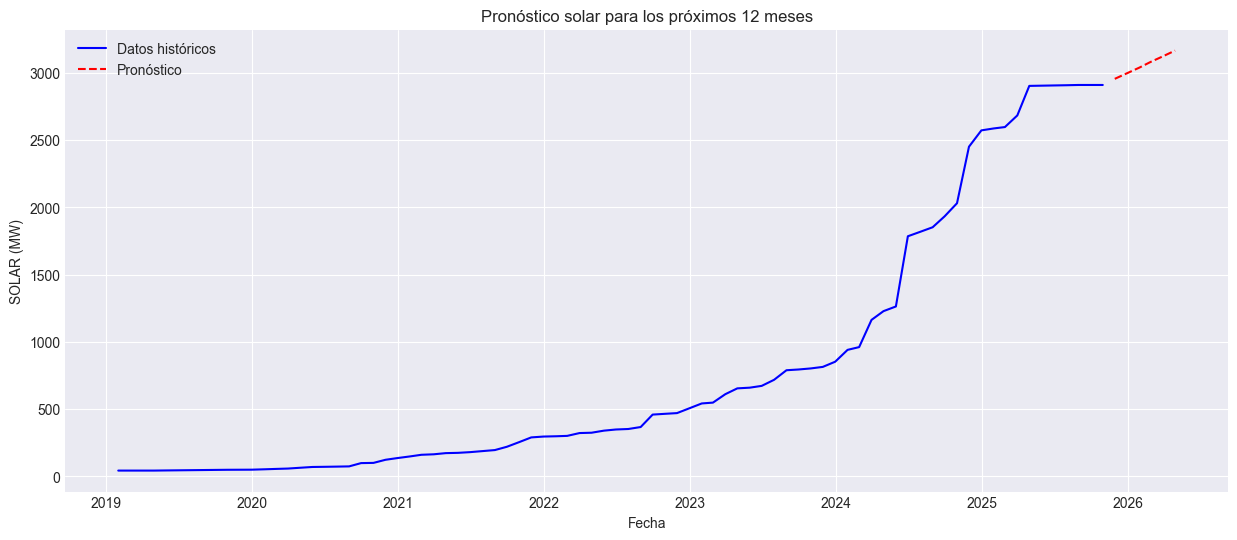

In [79]:
modelos = [
    {'nombre': 'Simple', 'tipo': 'ETS', 'error': 'add', 'trend': None, 'seasonal': None},
    
    {'nombre': 'Holt-add-add-none', 'tipo': 'ETS', 'error': 'add', 'trend': 'add', 'seasonal': None},
    {'nombre': 'Holt-add-mul-none', 'tipo': 'ETS', 'error': 'add', 'trend': 'mul', 'seasonal': None},
    {'nombre': 'Holt_mul_add_add', 'tipo': 'ETS', 'error': 'mul', 'trend': 'add', 'seasonal': None},
    {'nombre': 'Holt_mul_mul_none', 'tipo': 'ETS', 'error': 'mul', 'trend': 'mul', 'seasonal': None},

    
    {'nombre': 'Holt-Winters add_add_add', 'tipo': 'ETS', 'error': 'add', 'trend': 'add', 'seasonal': 'add'},
    {'nombre': 'Holt-Winters add_add_mul', 'tipo': 'ETS', 'error': 'add', 'trend': 'add', 'seasonal': 'mul'},
    {'nombre': 'Holt-Winters add_mul_add', 'tipo': 'ETS', 'error': 'add', 'trend': 'mul', 'seasonal': 'add'},
    {'nombre': 'Holt-Winters add_mul_mul', 'tipo': 'ETS', 'error': 'add', 'trend': 'mul', 'seasonal': 'mul'},
    {'nombre': 'Holt-Winters mul_add_add', 'tipo': 'ETS', 'error': 'mul', 'trend': 'add', 'seasonal': 'add'},
    {'nombre': 'Holt-Winters mul_add_mul', 'tipo': 'ETS', 'error': 'mul', 'trend': 'add', 'seasonal': 'mul'},
    {'nombre': 'Holt-Winters mul_mul_add', 'tipo': 'ETS', 'error': 'mul', 'trend': 'mul', 'seasonal': 'add'},
    {'nombre': 'Holt-Winters mul_mul_mul', 'tipo': 'ETS', 'error': 'mul', 'trend': 'mul', 'seasonal': 'mul'},


    {'nombre': 'Holt-Winters add_none_add', 'tipo': 'ETS', 'error': 'add', 'trend': None, 'seasonal': 'add'},
    {'nombre': 'Holt-Winters add_none_mul', 'tipo': 'ETS', 'error': 'add', 'trend': None, 'seasonal': 'mul'},
    {'nombre': 'Holt-Winters mul_none_add', 'tipo': 'ETS', 'error': 'mul', 'trend': None, 'seasonal': 'add'},
    {'nombre': 'Holt-Winters mul_none_mul', 'tipo': 'ETS', 'error': 'mul', 'trend': None, 'seasonal': 'mul'}
]

graficar_pronosticos(modelos, 12)